# Clustering and Dimensionality Reduction

This notebook explores the use of clustering and dimensionality reduction techniques to analyze the data from nurses in the US. The questions we will try to answer are:
- Can we identify groups of nurses with similar characteristics?
- Can we reduce the dimensionality of the data to make it easier to analyze?
- Can we identify the most important features that explain the variance in the data?

In [5]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.simplefilter('ignore')

%config InlineBackend.figure_format = "retina"

## Data

In [6]:
# Read data
path_data = "https://github.com/pabloestradac/causalml-basics/raw/main/data/"
df = pd.read_csv(path_data + 'wages_nurses.csv')
df.tail()

,lwage,female,age,race,children,marital,education,RN_experience,left_nursing,country_ed_US,english_only,military,certificates,labor_union,work_setting,work_situation,level_care,care_specialty,state
5617,3.496087,1,72,white,0,widowed_divorced_sep,ed_assoc,51,left_0,1,1,never_served_mil,0,0,SET_long_term_inpatient,SIT_self_employed,LC_nursing_home,CC_no_patient_care,state_n13
5618,3.678408,1,50,white,0,never_married,ed_msn,14,left_0,1,1,never_served_mil,0,0,SET_hospital,SIT_agency_facility,LC_education,CC_emergency_care,state_n24
5619,3.952845,0,36,white,0,currently_married,ed_bsn,4,left_0,1,1,never_served_mil,2,1,SET_hospital,SIT_agency_facility,LC_inpatient,CC_oncology,state_n32
5620,3.957960,1,61,white,0,currently_married,ed_bsn,40,left_0,1,1,never_served_mil,0,0,SET_hospital,SIT_agency_facility,LC_inpatient,CC_no_patient_care,state_n37
5621,3.100270,1,38,white,0,currently_married,ed_assoc,3,left_0,1,1,never_served_mil,2,0,SET_hospital,SIT_agency_facility,LC_others,CC_medical_surgical,state_n29


## Principal Component Analysis

Principal Component Analysis (PCA) is a technique used to reduce the dimensionality of the data. It works by finding the directions in which the data varies the most and projecting the data onto these directions. This allows us to reduce the number of features in the data while retaining most of the information.

In [16]:
import patsy

model = '0 + ' + ' + '.join(df.columns.difference(['lwage']))
X = patsy.dmatrix(model, df, return_type='dataframe')
y = df[['lwage']]

In [17]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pca = Pipeline([('scaler', StandardScaler()),
                ('pca', PCA())])

PCA is used to decompose a multivariate dataset in a set of successive orthogonal components that explain a maximum amount of the variance. In scikit-learn, `PCA` is implemented as a transformer object that learns $n$ components in its `fit` method, and can be used on new data to project it on these components.

It is common to adjust the parameters of an estimator within a pipeline. This parameter is therefore nested because it belongs to a particular sub-step. Parameters of the estimators in the pipeline are accessible using the `<estimator>__<parameter>` syntax.

In [26]:
pca.set_params(pca__n_components=2)

X_pca = pca.fit_transform(X)

# Display variance explained by each component
explained_variance = pca[1].explained_variance_ratio_
print("Explained variance ratio:", explained_variance)

Explained variance ratio: [0.03933084 0.02599752]


The amount of variance explained by the first two components is veeery low. Remember that this is equal to the `n_components` largest eigenvalues of the covariance matrix of X.

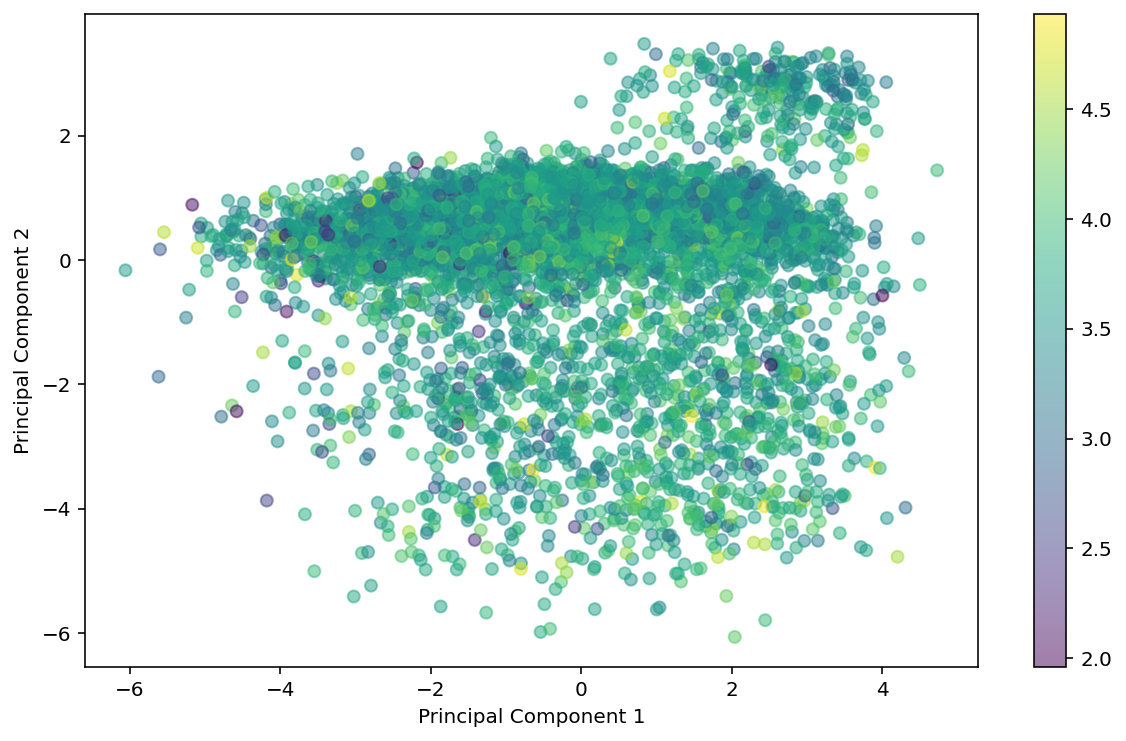

In [27]:
plt.figure(figsize=(10, 6))

plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.values.ravel(), cmap='viridis', alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

PCA can also be used to reconstruct the original data with reduced dimensions.

Reconstruction error indicates the loss of information due to dimensionality reduction.

In [ ]:
# Reconstructing the original data (approximation)
X_reconstructed = pca.inverse_transform(X_pca)

# Reconstruction error
reconstruction_error = np.mean((X_scaled - X_reconstructed)**2)
print(f"Reconstruction error: {reconstruction_error:.4f}")

Advantages:
- Reduces dimensionality, allowing for easier visualization and analysis of data.
- Can help remove noise in data by ignoring small principal components.

Limitations:
- PCA assumes that the directions with largest variances are the most important.
- Not ideal for datasets where relationships between variables are nonlinear.

Conclusion: PCA is a powerful tool for reducing dimensionality, but it's essential to use it in contexts where its assumptions hold true.

The PCA object also provides a probabilistic interpretation of the PCA that can give a likelihood of data based on the amount of variance it explains. As such it implements a score method that can be used in cross-validation:

In [ ]:
from sklearn.covariance import LedoitWolf, ShrunkCovariance
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.model_selection import GridSearchCV, cross_val_score

n_components = np.arange(0, n_features, 5)  # options for n_components


def compute_scores(X):
    pca = PCA(svd_solver="full")
    fa = FactorAnalysis()

    pca_scores, fa_scores = [], []
    for n in n_components:
        pca.n_components = n
        fa.n_components = n
        pca_scores.append(np.mean(cross_val_score(pca, X)))
        fa_scores.append(np.mean(cross_val_score(fa, X)))

    return pca_scores, fa_scores


def shrunk_cov_score(X):
    shrinkages = np.logspace(-2, 0, 30)
    cv = GridSearchCV(ShrunkCovariance(), {"shrinkage": shrinkages})
    return np.mean(cross_val_score(cv.fit(X).best_estimator_, X))


def lw_score(X):
    return np.mean(cross_val_score(LedoitWolf(), X))


for X, title in [(X_homo, "Homoscedastic Noise"), (X_hetero, "Heteroscedastic Noise")]:
    pca_scores, fa_scores = compute_scores(X)
    n_components_pca = n_components[np.argmax(pca_scores)]
    n_components_fa = n_components[np.argmax(fa_scores)]

    pca = PCA(svd_solver="full", n_components="mle")
    pca.fit(X)
    n_components_pca_mle = pca.n_components_

    print("best n_components by PCA CV = %d" % n_components_pca)
    print("best n_components by FactorAnalysis CV = %d" % n_components_fa)
    print("best n_components by PCA MLE = %d" % n_components_pca_mle)

    plt.figure()
    plt.plot(n_components, pca_scores, "b", label="PCA scores")
    plt.plot(n_components, fa_scores, "r", label="FA scores")
    plt.axvline(rank, color="g", label="TRUTH: %d" % rank, linestyle="-")
    plt.axvline(
        n_components_pca,
        color="b",
        label="PCA CV: %d" % n_components_pca,
        linestyle="--",
    )
    plt.axvline(
        n_components_fa,
        color="r",
        label="FactorAnalysis CV: %d" % n_components_fa,
        linestyle="--",
    )
    plt.axvline(
        n_components_pca_mle,
        color="k",
        label="PCA MLE: %d" % n_components_pca_mle,
        linestyle="--",
    )

    # compare with other covariance estimators
    plt.axhline(
        shrunk_cov_score(X),
        color="violet",
        label="Shrunk Covariance MLE",
        linestyle="-.",
    )
    plt.axhline(
        lw_score(X),
        color="orange",
        label="LedoitWolf MLE" % n_components_pca_mle,
        linestyle="-.",
    )

    plt.xlabel("nb of components")
    plt.ylabel("CV scores")
    plt.legend(loc="lower right")
    plt.title(title)

plt.show()